# Wstęp
Zadanie 8 obejmuje zagadnienie segmentacji obrazów i wprowadza konwolucyjne modele o architekturze enkoder-dekoder. Modele takie wykorzystują konwolucje i downsampling aby uzyskać mapę cech o mniejszej rozdzielczości (enkoder), a następnie "dekodują" otrzymaną ją z powrotem do większej rozdzielczości aby wydobyć w rozdzielczości oryginalnego obrazka interesujące nas informacje semantyczne - np. segmentację obrazka na poszczególne obiekty. Architektury tego typu mają również zastosowania w modelach generatywnych, w zadaniach które ogólnie określamy jako *image to image translation*.

# Cel ćwiczenia

Celem ćwiczenia jest poznanie



*   metod upsamplingu w sieciach konwolucyjnych
*   architektur konwolucyjnych o strukturze enkoder-dekoder
*   wykorzystania sieci głębokich w segmentacji danych obrazowych





# Upsampling w sieciach konwolucyjnych

Na laboratorium 5 dowiedzieliśmy się już, że do zmniejszania rozdzielczości mapy cech możemy wykorzystać dwa podejścia - pooling lub warstwę konwolucyjną z odpowiednim parametrem `stride`. Podobnie jest ze zwiększaniem rozdzielczości.

Wersja prostsza, odwrotność poolingu, to `torch.nn.Upsample`. Jest to pozbawiona uczących się parametrów klasa dająca wybór trybu interpolacji.

In [1]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

upsampler = torch.nn.Upsample(scale_factor=2)

dummy_input = torch.zeros((3,3,32,32))
upsampler(dummy_input).shape

Using device: mps


torch.Size([3, 3, 64, 64])

In [2]:
from matplotlib import pyplot as plt

def plot_results(results):
    num_rows = len(results)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * len(results)))
    if num_rows == 1:
        axes = [axes]
    for ax, (key, values) in zip(axes, results.items()):

        epochs = range(1, len(values['train_loss']) + 1)

        ax[0].plot(epochs, [x.item() for x in values['train_loss']], label='Train Loss')
        ax[0].plot(epochs, [x.item() for x in values['test_loss']], label='Test Loss')
        ax[0].set_title(f"{key} Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].plot(epochs, [x.item() for x in values['train_acc']], label='Train Accuracy')
        ax[1].plot(epochs, [x.item() for x in values['test_acc']], label='Test Accuracy')
        ax[1].set_title(f"{key} Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

    plt.tight_layout()
    plt.show()

Klasa `torch.nn.ConvTranspose2d` to natomiast ucząca się operacja "odwracania" konwolucji. Jej relacja wymiarów wejście-wyjście powinna być taka, jak wyjście do wejścia dla warstwy `torch.nn.Conv2d` o analogicznych parametrach konstruktora. Innymi słowy, jeśli tensor przepuścimy przez konwolucję, a następnie konwolucję transponowaną, oczekujemy powrotu do początkowej szerokości i wysokości - o ile oczywiście parametry tych dwóch warstw będą się ze sobą zgadzać.

Konwolucja transponowana wprowadza dodatkowy parametr `output_padding`. Jest on potrzebny dlatego, że ze względu na zaokrąglanie wymiarów dla zwyczajnej konwolucji wykorzystującej `stride>1`, na podstawie wymiaru jej wyjścia nie da się jednoznacznie określić wymiaru jej wejścia. Aby spełnić założenie że warstwa `torch.nn.ConvTranspose2d` odwraca zmianę wymiarów której dokonuje `torch.nn.Conv2d`, potrzebny jest więc dodatkowy parametr pozwalający doprecyzować oczekiwany rozmiar. W razie problemów z uzyskaniem właściwego rozmiaru, dokumentacja torcha podaje konkrenty wzór na zależność między parametrami warstwy a szeokością i wysokością jej wyniku.

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

In [3]:
upsampler = torch.nn.ConvTranspose2d(3,3,2, stride=2)

dummy_input = torch.zeros((3,3,32,32))

print(f"kształt po upsamplingu: {upsampler(dummy_input).shape}")

conv = torch.nn.Conv2d(3,3,3, stride=2, padding=1)
deconv = torch.nn.ConvTranspose2d(3,3,3, stride=2, padding=1)
fixed_deconv = torch.nn.ConvTranspose2d(3,3,3, stride=2, padding=1, output_padding=1)

print(f"kształt po konwolucji: {conv(dummy_input).shape}")
print(f"kształt po konwolucji i konw. transponowanej: {deconv(conv(dummy_input)).shape}")
print(f"j.w., ale z output_padding: {fixed_deconv(conv(dummy_input)).shape}")

kształt po upsamplingu: torch.Size([3, 3, 64, 64])
kształt po konwolucji: torch.Size([3, 3, 16, 16])
kształt po konwolucji i konw. transponowanej: torch.Size([3, 3, 31, 31])
j.w., ale z output_padding: torch.Size([3, 3, 32, 32])


# Segmentacja obrazu

Model enkoder-dekoder testować będziemy w zadaniu nadzorowanej segmentacji. Oznacza to, że dla obrazu wejściowego musimy znaleźć etykiety ze z góry wyznaczonego zbioru, przewidujemy je jednak nie dla całego obrazu, a na poziomie każdego piksela. Skorzystamy z dostępnego w `torchvision.datasets` zbioru VOC. Najpierw jednak musimy zdefiniować transformację danych, kóra będzie nieco bardziej skomplikowana niż do tej pory.

Ponieważ etykiety są podane również jako obraz, trzeba pamiętać, że augmentacje losowe muszą zgadzać się pomiędzy obrazkiem a etykietą. Niestety, każde wywołanie funkcji w standardowym przepływie danych z wykorzystaniem `transforms` losuje augmentację na nowo. Aby uzyskać identyczną augmentację, konieczne będzie wykorzystanie funkcji z `torchvision.transforms.functional`.

Druga istotna zmiana to konwersja do tensora. Aby zachować `target` jako tensor całkowitoliczbowy, musimy zastosować własną alternatywę dla ToTensor(), jako że `ToTensor` zawsze przekształca obrazy do tensora zmiennmoprzecinkowego w zakresie [0,1].

# Zadanie 1

Zdefiniuj transformację, która dla pary wejściowej `image, target` zwraca zaugmentowane w identyczny sposób obraz i etykiety. Transformacja powinna obejmować:

*   dowolną augmentację na danych wejściowych
*   padding to stałego rozmiaru (w przypadku etykiet, padować trzeba wartością 255)
*   konwersję do tensora - zmiennoprzecinkowego dla obrazu, całkowitoliczbowego dla etykiety

Zdefiniuj również odpowiednią transformację dla zbioru testowego, pamiętając że dane testowe nie powinny byc augmentowane.



In [4]:
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import numpy as np
import random
import math
import PIL

def calculate_new_size_after_rotation(width, height, angle):
    """
    Calculate the bounding box size that can contain a rotated rectangle.
    """
    radians = math.radians(angle)
    new_width = abs(width * math.cos(radians)) + abs(height * math.sin(radians))
    new_height = abs(width * math.sin(radians)) + abs(height * math.cos(radians))
    return math.ceil(new_width), math.ceil(new_height)

def center_and_resize(image, target, output_size=(128, 128)):
    """
    Resizes and pads the input image and target to the specified output size, centering them.
    """
    # Resize both images to fit within a quarter of their original size
    new_size = (image.size[1] // 4, image.size[0] // 4)
    image = TF.resize(image, size=new_size, interpolation=PIL.Image.NEAREST)
    target = TF.resize(target, size=new_size, interpolation=PIL.Image.NEAREST)

    # Calculate padding to center the image within the output size
    pad_top = (output_size[1] - new_size[0]) // 2
    pad_bottom = output_size[1] - new_size[0] - pad_top
    pad_left = (output_size[0] - new_size[1]) // 2
    pad_right = output_size[0] - new_size[1] - pad_left

    # Apply padding to center the image and target
    image = TF.pad(image, padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0)
    target = TF.pad(target, padding=(pad_left, pad_top, pad_right, pad_bottom), fill=255)

    # Convert image to tensor
    image = TF.to_tensor(image)
    target = torch.tensor(np.array(target), dtype=torch.long)

    # Adjust target labels (background: 0, object: 1, ignore: 255)
    target = torch.where((target == 0) | (target == 255), target, torch.tensor(1, dtype=torch.long))

    return image, target

def pair_transforms(image, target):
    """
    Applies random transformations to the input image-target pair and centers the result.
    """
    # Apply a random rotation between -30 and 30 degrees
    angle = random.uniform(-30, 30)
    width, height = image.size
    new_width, new_height = calculate_new_size_after_rotation(width, height, angle)

    # Apply padding to the original images to handle rotation without cutting off
    pad_top = (new_height - height) // 2
    pad_bottom = new_height - height - pad_top
    pad_left = (new_width - width) // 2
    pad_right = new_width - width - pad_left

    image = TF.pad(image, padding=(pad_left, pad_top, pad_right, pad_bottom), fill=0)
    target = TF.pad(target, padding=(pad_left, pad_top, pad_right, pad_bottom), fill=255)

    # Apply the rotation
    image = TF.rotate(image, angle, fill=0)
    target = TF.rotate(target, angle, fill=255)

    # Center the image and target
    return center_and_resize(image, target)

def test_pair_transforms(image, target):
    """
    Test function that only centers and resizes the image-target pair without additional random transformations.
    """
    return center_and_resize(image, target)


Załaduj zbiór danych ze zeefiniowaną transformacją, a następnie zweryfikuj, że augmentacja zgadza się pomiędzy obrazem a etykietą. 

In [5]:
data = datasets.VOCSegmentation("root", download=True, transforms=pair_transforms)

Using downloaded and verified file: root/VOCtrainval_11-May-2012.tar
Extracting root/VOCtrainval_11-May-2012.tar to root


In [6]:
test_data = datasets.VOCSegmentation("root", download=True, image_set="val", transforms=test_pair_transforms)

Using downloaded and verified file: root/VOCtrainval_11-May-2012.tar
Extracting root/VOCtrainval_11-May-2012.tar to root


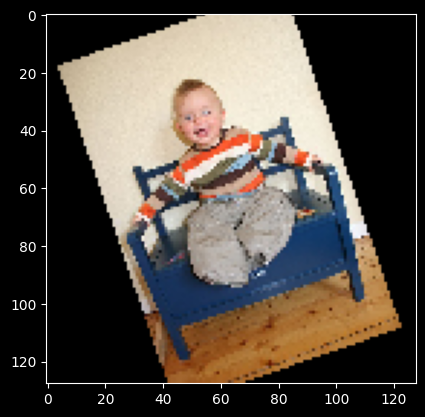

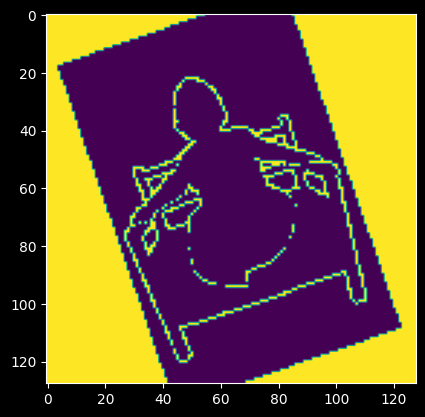

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])


In [7]:
from matplotlib import pyplot as plt

image, label = data[100]
plt.imshow(image.permute(1,2,0))
plt.show()
plt.imshow(label)
plt.show()
print(label)

Zauważ, że wartością 255 oznaczone są "krawędzie" pomiędzy właściwymi etykietami. Etykieta 255 nie powinna być brana pod uwagę przy wyliczaniu kosztu i metryk jakości segmentacji.

# Architektura enkoder-dekoder


Możemy przejść do zdefiniowania architektury enkoder-dekoder. Achitektura ta powinna przetworzyć obraz do niższej rozdzielczości, a następnie zwiększyć jego wymiar z powrotem do oryginalnego. Podobnie jak w standardowych sieciach konwolucyjnych do klasyfikacji, przydatne jest zwiększanie liczby kanałów wraz ze zmniejszaniem rozdzielczości. Pozwala to na zachowanie informacji po downsamplingu, oraz daje możliwość wyuczenia najbardziej złożonych zależności tam gdzie jest to najbardziej istotne, czyli w warstwach operujących na najniższej rozdzielczości gdzie pole recepcyjne filtra obejmuje największy fragment obrazu. Przy upsamplingu, liczba kanałów typowo będzie się zmniejszać. Dodatkowo, skrótowe połączenia według schematu: pierwsza warstwa do ostatniej, druga do przedostaniej etc. są typowym elementem takich architektur.

# Zadanie 2

Zmodyfikuj funkcję forward klasy SimpleEncoderDecoder tak, aby dodać połączenia skrótowe między warstwami o tej samej rozdzielczości..

In [8]:
# from typing import List

# class SimpleEncoderDecoder(torch.nn.Module):
#   def __init__(self, channels, out_labels):
#     super().__init__()
#     self.conv_1 = torch.nn.Conv2d(3, channels[0], 3, padding=1)
#     self.conv_2 = torch.nn.Conv2d(channels[0], channels[1], 3, padding=1)
#     self.conv_3 = torch.nn.Conv2d(channels[1], channels[2], 3, padding=1)
#     self.conv_4 = torch.nn.Conv2d(channels[2], channels[2], 3, padding=1)
#     self.up_conv1 = torch.nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
#     self.up_conv2 = torch.nn.ConvTranspose2d(channels[1], channels[0], 2, stride=2)
#     self.up_conv3 = torch.nn.ConvTranspose2d(channels[0], out_labels, 2, stride=2)
#     self.pool = torch.nn.MaxPool2d(2)
#     self.act = torch.nn.ReLU()
#     self.bnorm = torch.nn.BatchNorm2d(channels[2])
  
#   def forward(self, x):
#     x = self.act(self.conv_1(x))
#     x = self.pool(x)
#     x = self.act(self.conv_2(x))
#     x = self.pool(x)
#     x = self.act(self.conv_3(x))
#     x = self.pool(x)
#     x = self.bnorm(x)
#     x = self.act(self.conv_4(x))
#     x = self.act(self.up_conv1(x))
#     x = self.act(self.up_conv2(x))
#     x = self.act(self.up_conv3(x))
#     return x

In [9]:
import torch.nn.functional as F
import torch.nn as nn

class SimpleEncoderDecoder(nn.Module):
    def __init__(self, channels, out_labels):
        super().__init__()
        # Encoder
        self.conv_1 = nn.Conv2d(3, channels[0], 3, padding=1)
        self.conv_2 = nn.Conv2d(channels[0], channels[1], 3, padding=1)
        self.conv_3 = nn.Conv2d(channels[1], channels[2], 3, padding=1)
        self.conv_4 = nn.Conv2d(channels[2], channels[2], 3, padding=1)
        
        # Decoder
        self.up_conv1 = nn.ConvTranspose2d(channels[2] * 2, channels[1], 2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(channels[1] * 2, channels[0], 2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(channels[0] * 2, out_labels,  2, stride=2)
        
        self.pool = nn.MaxPool2d(2)
        self.act = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(channels[2])

    def forward(self, x):
        x1 = self.act(self.conv_1(x))
        x1_pooled = self.pool(x1)
        x2 = self.act(self.conv_2(x1_pooled))
        x2_pooled = self.pool(x2)
        x3 = self.act(self.conv_3(x2_pooled))
        x3_pooled = self.pool(x3)
        x4 = self.bnorm(self.act(self.conv_4(x3_pooled)))
        
        # Decoder with concatenation skip connections
        x_up1 = self.act(self.up_conv1(torch.cat([x4,    F.interpolate(x3, x4.shape[2:])],    dim=1)))
        x_up2 = self.act(self.up_conv2(torch.cat([x_up1, F.interpolate(x2, x_up1.shape[2:])], dim=1)))
        x_up3 = self.act(self.up_conv3(torch.cat([x_up2, F.interpolate(x1, x_up2.shape[2:])], dim=1)))
        
        return x_up3

Zweryfikuj działanie sieci:

In [10]:
model = SimpleEncoderDecoder([32,64,128], 21).to(device)

dummy_data = torch.zeros((32,3,64,64)).to(device)

assert(model(dummy_data).shape==(32,21,64,64))

Zdefinujmy kod pomocniczy - jak zwykle można zastąpić własnym, uwzględniającym ulepszenia z poprzednich laboratoriów. Zauważ, że ze funkcja entropii krzyżowej nie wymaga adaptacji do zadania. Natomiast implementacja `count_correct` została zmieniona tak, aby nie zliczać pikseli oznaczonych wartością 255.

In [11]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    not_bg = (y_true != 255).float()
    return ((preds == y_true).float() * not_bg).sum() / not_bg.sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.to(device))
        all += 1
        loss += loss_fn(y_pred, y_batch.to(device)).sum()
        correct += count_correct(y_pred, y_batch.to(device))
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  metrics = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
  }
  for epoch in range(epochs):
      for X_batch, y_batch in train_dl:
          y_pred = model(X_batch.to(device))
          loss = loss_fn(y_pred, y_batch.to(device))
          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              metrics['train_loss'].append(train_loss)
              metrics['train_acc'].append(train_acc)
              metrics['test_loss'].append(val_loss)
              metrics['test_acc'].append(val_acc)
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

  return metrics

Wyucz sieć na danych z VOCSegmentation.

Uwaga: VOCSegmentation to dość trudny zbiór, nie trzeba tu osiągać wyjątkowo dobrych wyników.



In [12]:
model = SimpleEncoderDecoder([32,64,128], 2).to(device)

loss = torch.nn.CrossEntropyLoss(ignore_index=255)
train_dl = DataLoader(data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32)
optimizer = optim.Adam(model.parameters())
results = {}
results['Simple Encoder Decoder'] = fit(model, optimizer, loss, train_dl, test_dl, 50, True)

Epoch 0: train loss = 0.598 (acc: 0.730), validation loss = 0.595 (acc: 0.730)
Epoch 1: train loss = 0.549 (acc: 0.733), validation loss = 0.545 (acc: 0.733)
Epoch 2: train loss = 0.558 (acc: 0.735), validation loss = 0.552 (acc: 0.737)
Epoch 3: train loss = 0.534 (acc: 0.752), validation loss = 0.529 (acc: 0.754)
Epoch 4: train loss = 0.530 (acc: 0.755), validation loss = 0.523 (acc: 0.756)
Epoch 5: train loss = 0.543 (acc: 0.742), validation loss = 0.538 (acc: 0.744)
Epoch 6: train loss = 0.530 (acc: 0.760), validation loss = 0.525 (acc: 0.760)
Epoch 7: train loss = 0.555 (acc: 0.749), validation loss = 0.546 (acc: 0.749)
Epoch 8: train loss = 0.526 (acc: 0.763), validation loss = 0.519 (acc: 0.763)
Epoch 9: train loss = 0.523 (acc: 0.765), validation loss = 0.519 (acc: 0.765)
Epoch 10: train loss = 0.519 (acc: 0.768), validation loss = 0.514 (acc: 0.767)
Epoch 11: train loss = 0.516 (acc: 0.772), validation loss = 0.515 (acc: 0.769)
Epoch 12: train loss = 0.507 (acc: 0.775), validat

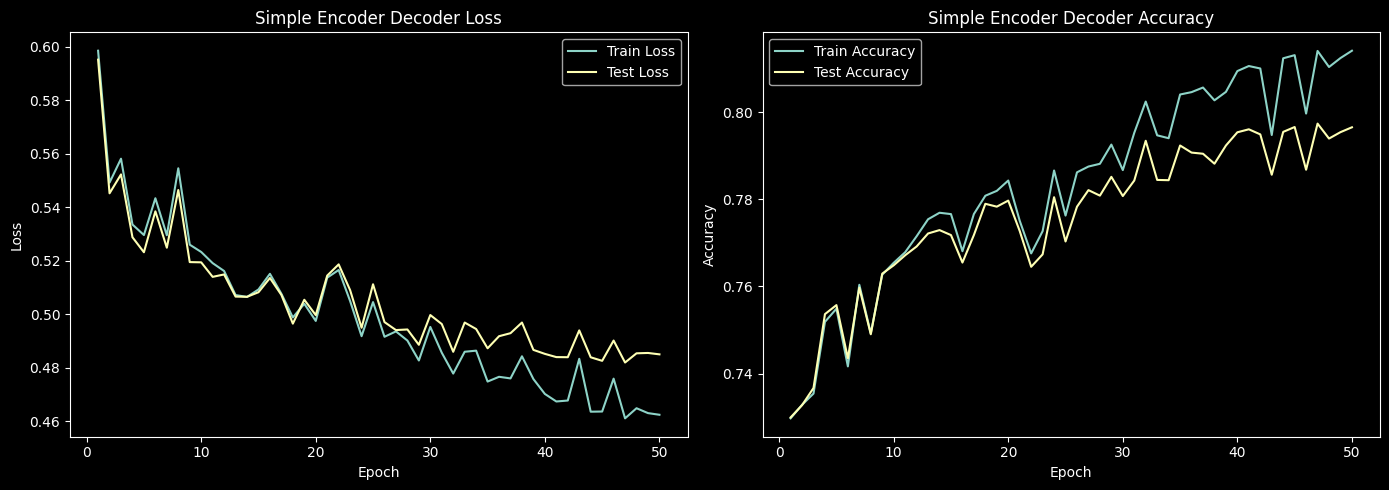

In [13]:
plot_results(results)

# Zadanie 3

Zdefiniuj parametryzowalną klasę EncoderDecoder, umożliwiającą wybór liczby warstw i liczby kanałów w poszczególnych warstwach. Klasa powinna dodawać połączenia skrótowe pomiędzy warstwami w początkowej a końcowej części architektury o tej samej rozdzielczości. Połączenia skrótowe powinny działać przez konkatenację.

Klasa powinna umożlwiać wybór pomiędzy upsamplingiem z wykorzsytaniem `ConvTranspose2D` a `torch.nn.Upsample`. Sprawdź wyniki tej drugiej opcji z parametrami analogicznymi do testów `SimpleEncoderDecoder` na segmentacji VOC.



In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List

class ParametrizedEncoderDecoder(nn.Module):
    def __init__(self, encoder_channels: List[int], decoder_channels: List[int], out_labels: int, use_transposed_conv: bool = True):
        super().__init__()
        self.encoder_channels = encoder_channels
        self.decoder_channels = decoder_channels
        self.use_transposed_conv = use_transposed_conv

        # Encoder layers
        self.encoder = nn.ModuleList()
        in_channels = 3
        for out_channels in encoder_channels:
            self.encoder.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.MaxPool2d(2)
            ))
            in_channels = out_channels

        # Decoder layers
        self.decoder = nn.ModuleList()
        for i, out_channels in enumerate(decoder_channels):
            if use_transposed_conv:
                up_layer = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
            else:
                up_layer = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(in_channels, out_channels, 3, padding=1)
                )

            self.decoder.append(nn.Sequential(
                up_layer,
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            ))
            in_channels = out_channels + encoder_channels[len(encoder_channels) - i - 1]

        # Final output layer
        self.final_conv = nn.Conv2d(in_channels, out_labels, 1)

    def forward(self, x):
        encoder_outputs = []

        # Pass through the encoder, saving each layer output for skip connections
        for layer in self.encoder:
            x = layer(x)
            encoder_outputs.append(x)

        encoder_outputs = encoder_outputs[::-1]

        # Pass through the decoder, using skip connections
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            if i < len(encoder_outputs):
                skip = encoder_outputs[i]
                # Ensure skip connection has the same size as the current x
                if x.shape[2:] != skip.shape[2:]:
                    skip = F.interpolate(skip, size=x.shape[2:], mode='nearest')
                x = torch.cat([x, skip], dim=1)

        # Final classification layer
        x = self.final_conv(x)

        # Ensure output has the same shape as the target
        return F.interpolate(x, size=(128, 128), mode='nearest')

In [15]:
encoder_channels = [32, 64, 128]
decoder_channels = [64, 32]
out_labels = 2

model = ParametrizedEncoderDecoder(encoder_channels, decoder_channels, out_labels, use_transposed_conv=False).to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
train_dl = DataLoader(data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32)
optimizer = optim.Adam(model.parameters())

results['Parametrized Encoder Decoder Upsample'] = fit(model, optimizer, loss_fn, train_dl, test_dl, epochs=50, print_metrics=True)

Epoch 0: train loss = 0.554 (acc: 0.733), validation loss = 0.549 (acc: 0.734)
Epoch 1: train loss = 0.494 (acc: 0.754), validation loss = 0.484 (acc: 0.757)
Epoch 2: train loss = 0.494 (acc: 0.751), validation loss = 0.487 (acc: 0.753)
Epoch 3: train loss = 0.479 (acc: 0.760), validation loss = 0.477 (acc: 0.759)
Epoch 4: train loss = 0.463 (acc: 0.772), validation loss = 0.459 (acc: 0.772)
Epoch 5: train loss = 0.457 (acc: 0.777), validation loss = 0.452 (acc: 0.777)
Epoch 6: train loss = 0.452 (acc: 0.781), validation loss = 0.450 (acc: 0.780)
Epoch 7: train loss = 0.444 (acc: 0.785), validation loss = 0.443 (acc: 0.782)
Epoch 8: train loss = 0.466 (acc: 0.777), validation loss = 0.466 (acc: 0.772)
Epoch 9: train loss = 0.460 (acc: 0.782), validation loss = 0.458 (acc: 0.778)
Epoch 10: train loss = 0.463 (acc: 0.775), validation loss = 0.466 (acc: 0.770)
Epoch 11: train loss = 0.440 (acc: 0.787), validation loss = 0.441 (acc: 0.783)
Epoch 12: train loss = 0.451 (acc: 0.781), validat

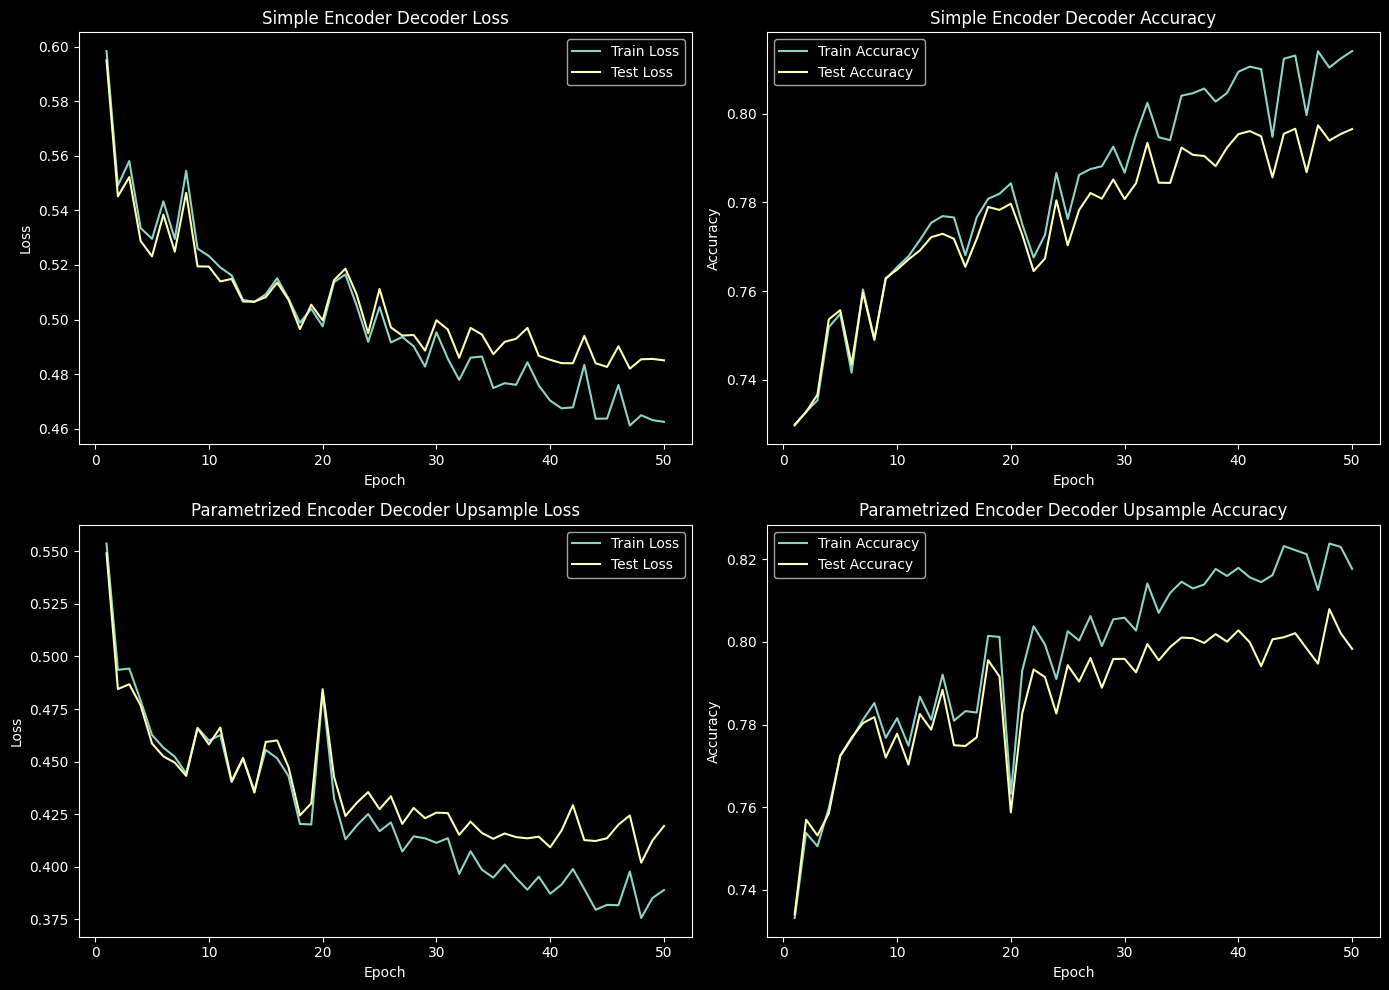

In [16]:
plot_results(results)

In [17]:
model = ParametrizedEncoderDecoder(encoder_channels, decoder_channels, out_labels, use_transposed_conv=True).to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
train_dl = DataLoader(data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32)
optimizer = optim.Adam(model.parameters())

results['Parametrized Encoder Decoder Transpose'] = fit(model, optimizer, loss_fn, train_dl, test_dl, epochs=50, print_metrics=True)

Epoch 0: train loss = 0.571 (acc: 0.733), validation loss = 0.567 (acc: 0.734)
Epoch 1: train loss = 0.498 (acc: 0.753), validation loss = 0.490 (acc: 0.759)
Epoch 2: train loss = 0.499 (acc: 0.750), validation loss = 0.494 (acc: 0.748)
Epoch 3: train loss = 0.482 (acc: 0.762), validation loss = 0.474 (acc: 0.762)
Epoch 4: train loss = 0.478 (acc: 0.763), validation loss = 0.473 (acc: 0.762)
Epoch 5: train loss = 0.483 (acc: 0.761), validation loss = 0.476 (acc: 0.763)
Epoch 6: train loss = 0.471 (acc: 0.768), validation loss = 0.469 (acc: 0.766)
Epoch 7: train loss = 0.466 (acc: 0.769), validation loss = 0.467 (acc: 0.765)
Epoch 8: train loss = 0.462 (acc: 0.773), validation loss = 0.463 (acc: 0.770)
Epoch 9: train loss = 0.474 (acc: 0.767), validation loss = 0.470 (acc: 0.767)
Epoch 10: train loss = 0.461 (acc: 0.773), validation loss = 0.461 (acc: 0.770)
Epoch 11: train loss = 0.464 (acc: 0.769), validation loss = 0.466 (acc: 0.765)
Epoch 12: train loss = 0.462 (acc: 0.774), validat

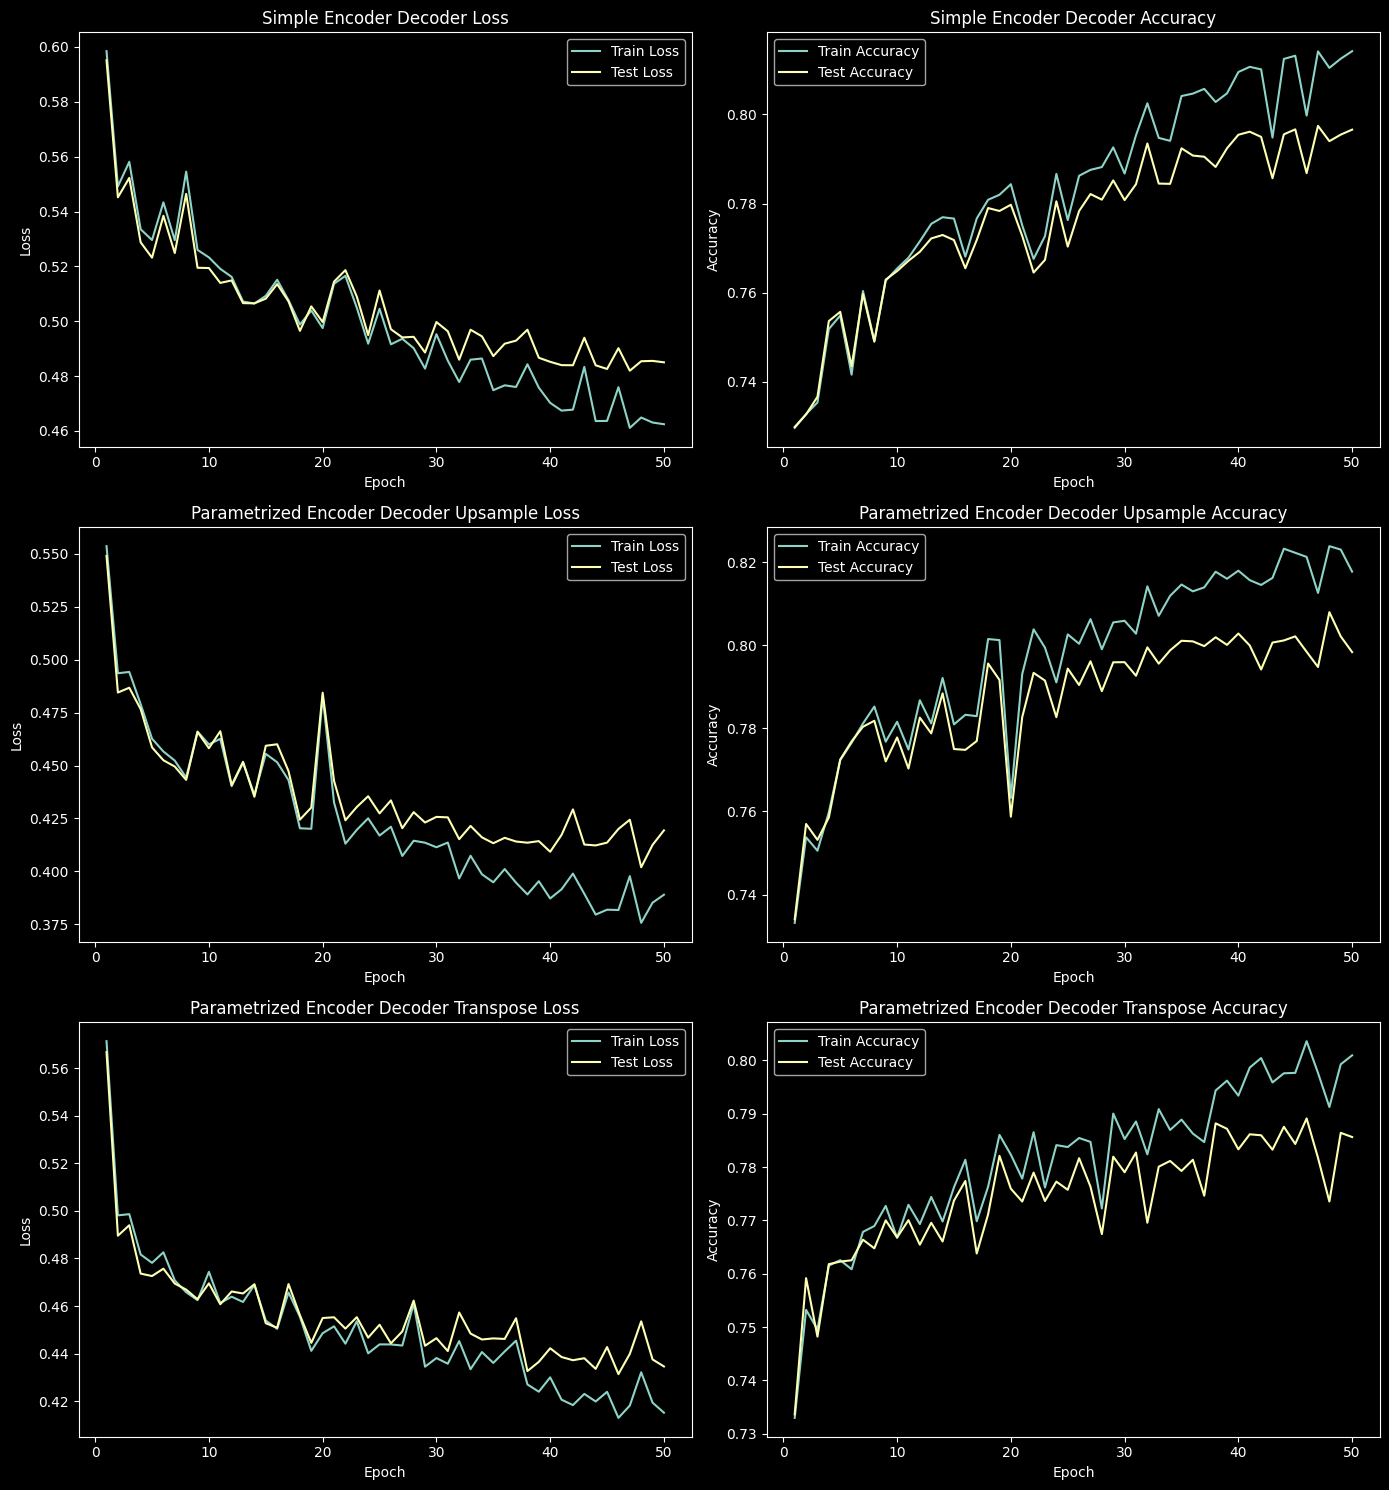

In [18]:
plot_results(results)